# Reproducing CNN2

**Progetto Machine Learning**, A. A. 2024/2025


Written by Marco Giunta

In [1]:
import shutil

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from small_norb_dataset import SmallNorbDataset
from torchinfo import summary

# Define some hyper-parameters
LEARNING_RATE = 1e-4
DECAY_RATE = 0.96
BATCH_SIZE = 32
EPOCHS = 100
DROPOUT = 0.5
SCALE_LIST = [1,3,5]

# Set the random seed
torch.manual_seed(123)

# Define the device where we want to run our mode
# If a CUDA-capable machine is available, then set the GPU as running device
# If a Apple ARM Mx-capable machine is available, then set the MPS as running device
torch_device = 'cpu'
if torch.cuda.is_available():
    torch_device = 'cuda'
elif torch.backends.mps.is_available():
    torch_device = 'mps'
DEVICE = torch.device(torch_device)

In [ ]:
import wandb
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="reproducing-cnn2-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "architecture": "CNN2",
    "dataset": "SmallNORB",
    "epochs": EPOCHS,
    "batch_size" : BATCH_SIZE,
    "activation": "ReLU",
    "num_classes": 5,
    }
)

In [2]:
# Images inside the SmallNORB dataset consists of 48,600 grayscale binocular images of
# size 96 × 96 pixels in 5 classes: four-legged animals, human figures, airplanes, trucks, and cars.
# We have to first convert them into torch.Tensor and then downsample to 48 × 48 pixels
transform = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Resize(size=(48,48))
            ])

# load the SmallNORB dataset
smallnorb_dataset = SmallNorbDataset(transform=transform)

On the SmallNORB dataset, the authors use the images taken from azimuths of degrees from 20 to 80 as the training set, degrees at 0 and 100 as the validation set, and the rest as the test set. (4.1 3D Viewpoint Generalization)

In [ ]:
# On the SmallNORB dataset there are 18 azimuths (0 to 340 every 20 degrees).
# In each image the azimuth is store as 0,2,4,...,34 (multiply by 10 to get the azimuth in degrees)
train_azimuth_values = [2,4,6,8]
#train_azimuth_values = [2,4,6,8,12,14]  # added more samples to train dataset
validation_azimuth_values = [0,10]
test_azimuth_values = list(range(12,36,2))
#test_azimuth_values = list(range(16,36,2)) # removed samples from test dataset

train_idx, validation_idx, test_idx = [], [], []
for i, (images, label, azimuth) in enumerate(smallnorb_dataset):

    if azimuth in train_azimuth_values:
        train_idx.append(i)
    elif azimuth in validation_azimuth_values:
        validation_idx.append(i)
    else:
        test_idx.append(i)

train_set = torch.utils.data.Subset(smallnorb_dataset, train_idx)
validation_set = torch.utils.data.Subset(smallnorb_dataset, validation_idx)
test_set = torch.utils.data.Subset(smallnorb_dataset, test_idx)

# Classes which images belong to
classes = ('animal', 'figure', 'airplane', 'truck', 'car')

print('Number of training images: {}'.format(len(train_set)))
print('Number of validation images: {}'.format(len(validation_set)))
print('Number of test images: {}'.format(len(test_set)))

# PyTorch data loaders
# Loading data from disk and organize it in batches
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        

Number of training images: 16200
Number of validation images: 5400
Number of test images: 27000


Show some sample, with label and azimuth value.

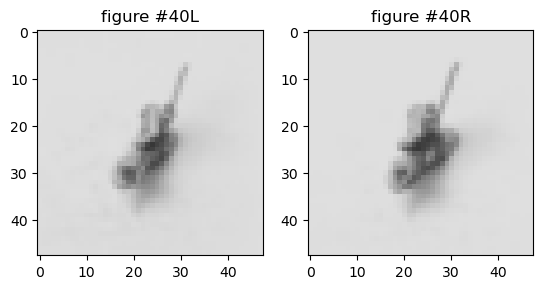

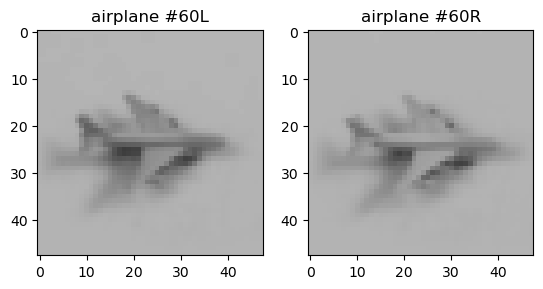

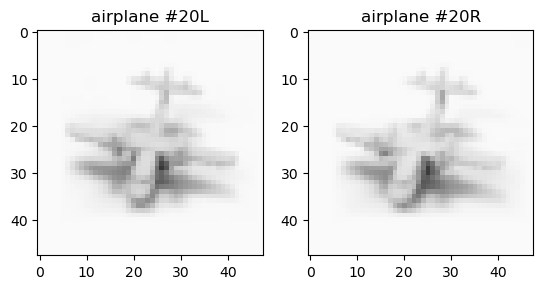

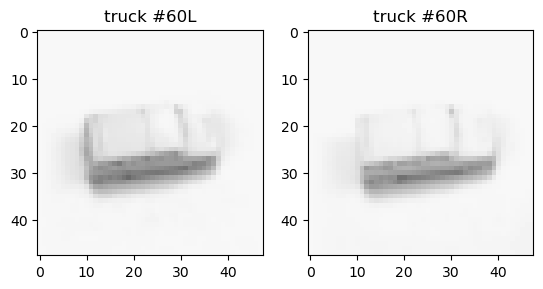

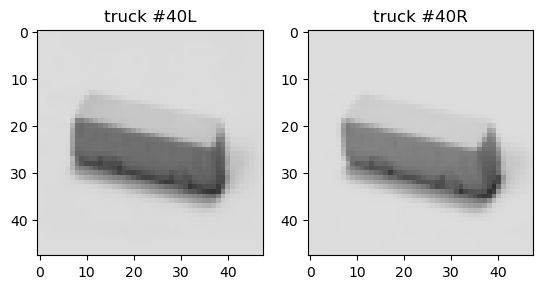

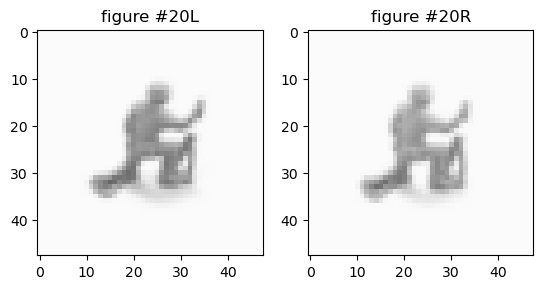

In [4]:
# Attempt to retrieve 5 items
for i, (images, label, azimuth) in enumerate(train_dataloader):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('{} #{}0L'.format(classes[label[i]], azimuth[i]))
    ax1.imshow(torchvision.transforms.ToPILImage()(images[0][i].squeeze()), cmap='gray', vmin=0, vmax=255)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('{} #{}0R'.format(classes[label[i]], azimuth[i]))
    ax2.imshow(torchvision.transforms.ToPILImage()(images[1][i].squeeze()), cmap='gray', vmin=0, vmax=255)
    if i == 5:
        break

## CNN2 model
Our CNN2 consists of 3 blocks. Each block has a CM pooling layer and a convolution layer. We use 3 scales (s= 0,1,2) in a CM pooling layer. 

In [5]:
class MonocularLayer(nn.Module):
    def __init__(self, filters, ksize, in_channels, pool_stride):
        super(MonocularLayer, self).__init__()
        self.out_channels = filters
        self.kernel_size = ksize
        self.in_channels = in_channels
        self.pool_stride = pool_stride
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, stride=1, padding='same', device=DEVICE),
            nn.ReLU()
        )
           
    # images = feature_maps
    def forward(self, images):
        pool_maps = self.cmpooling(images)
        pool_maps = torch.concat(pool_maps, axis=1)
        return self.conv(pool_maps.to(DEVICE))

    ## Utility function
    def cmpooling(self, images):
        scale_list = SCALE_LIST
        pool_stride = self.pool_stride
        # make sure the scale_list is in decending order
        # es. [1,3,5] => [5, 3, 1]
        if scale_list[0] - scale_list[1] < 0:
            scale_list = scale_list[::-1]
        
        # concentric multi-scale pooling
        # es. scale_list=[5, 3, 1] => offset=[0, 1, 2]
        offset = [0] + [-(scale_list[i+1] - scale_list[0])//2 for i in range(len(scale_list) - 1)]
        pool_maps = []
        for offset, scale in zip(offset, scale_list):
            slice_maps = images[0:, # all batch 
                                0:, # all layer
                                offset:offset + images.shape[2] - offset * 2, # image witdh
                                offset:offset + images.shape[3] - offset * 2] # image height
            # es.
            # images = [32, 2, 48, 48]
            # offset = 0
            # slice_maps = [32, 2, 0:48, 0:48]
            # 
            # offset = 1
            # slice_maps = [32, 2, 1:47, 1:47]
            #
            # offset = 2
            # slice_maps = [32, 2, 2:46, 2:46]
            pool_map = F.max_pool2d(input=slice_maps, kernel_size=scale, stride=pool_stride)
            pool_maps.append(pool_map)
    
        # assert same shape for all pool_map
        for i in range(len(pool_maps)-1):
            assert pool_maps[i].shape[1:] == pool_maps[-1].shape[1:]
        return pool_maps

The first, second, and third convolution layers have 6, 12, and 32 filters with sizes 5 × 5, 5 × 5, and 3 × 3 respectively. All filters use the stride of 1, and each unit uses the ReLU non-linearity.

In [6]:
class CNN2(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN2, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=DROPOUT),
            nn.Linear(9216, num_classes) # cross entropy loss needs logits, do not use SoftMax
        )

        self.monocular1l = MonocularLayer(filters=6, ksize=5, in_channels=6, pool_stride=2)
        self.monocular1r = MonocularLayer(filters=6, ksize=5, in_channels=6, pool_stride=2)
        self.monocular2l = MonocularLayer(filters=12, ksize=5, in_channels=36, pool_stride=1)
        self.monocular2r = MonocularLayer(filters=12, ksize=5, in_channels=36, pool_stride=1)
        self.monocular3l = MonocularLayer(filters=32, ksize=3, in_channels=72, pool_stride=1)
        self.monocular3r = MonocularLayer(filters=32, ksize=3, in_channels=72, pool_stride=1)

    def forward(self, left_eye, right_eye):
    
        # parallax augmentation
        parallax = left_eye - right_eye

        left = torch.concat([left_eye, -parallax], axis=1) # Size(2, 48, 48)
        right = torch.concat([right_eye, parallax], axis=1) # Size(2, 48, 48)

        left1 = self.monocular1l(left) # Size(6, 22, 22)
        right1 = self.monocular1r(right) # Size(6, 22, 22)
        
        left2 = self.monocular2l(torch.concat([left1, right1], axis=1)) # Size(12, 18, 18)
        right2 = self.monocular2r(torch.concat([right1, left1], axis=1)) # Size(12, 18, 18)

        left3 = self.monocular3l(torch.concat([left2, right2], axis=1)) # Size(32, 14, 14)
        right3 = self.monocular3r(torch.concat([right2, left2], axis=1)) # Size(32, 14, 14)
        
        merge_binocular = torch.concat([left3, right3], axis=1)

        merge_binocular = self.conv(merge_binocular)
        output = self.fc(merge_binocular)
    
        return output


Show model summary

In [ ]:
model = CNN2(num_classes=5)

# Move the model to the right device
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=DECAY_RATE, last_epoch=-1)

def accuracy(preds, labels):
  """
  Computes the accuracy between preds and labels

  preds:
    torch.tensor of size (B, N) where B is the batch size
    and N is the number of classes
    it contains the predicted probabilities for each class
  labels:
    torch.tensor of size (B) where each item is an integer
    taking value in [0,N-1]

  Returns:
    the accuracy between preds and labels
  """
  _, pred_idxs = torch.max(preds.data, 1)
  correct = (pred_idxs == labels).sum()
  total = labels.size(0)
  return float(correct) / total


 We use early stopping strategy for all experiments.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.2):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the quantity monitored not improving
        self.min_monitor = float("Inf") # Quantity to be monitored

    # return True when quantity monitored is not decreased by the `min_delta` for `patience` times 
    def early_stop_check(self, monitor):
        if ((monitor + self.min_delta) < self.min_monitor):
            self.min_monitor = monitor
            self.counter = 0  # reset the counter if quantity monitored decreased at least by min_delta
        elif ((monitor + self.min_delta) > self.min_monitor):
            self.counter += 1 # increase the counter if quantity monitored is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        print('Counter: {}'.format(self.counter))   
        return False
    
early_stopping = EarlyStopping(patience=20, min_delta=0.01)

In [ ]:
best_accuracy = 0
wandb.watch(model, log_freq=100)
for e in range(EPOCHS):
    train_acc=0
    train_loss=0
    for i, (images, label, azimuth) in enumerate(train_dataloader):
        # Let's set our model in training modality
        model.train()
        left_eyes = images[0]
        right_eyes = images[1]
        labels = label.type(torch.LongTensor)
        
        # Move the data to the right device
        left_eyes = left_eyes.to(DEVICE)
        right_eyes = right_eyes.to(DEVICE)
        labels = labels.to(DEVICE)

        # Perform the forward pass with CNN2
        out = model(left_eyes, right_eyes).to(DEVICE)

        # Define the loss function
        loss = F.cross_entropy(out, labels)

        # Use torch.softmax to obtain probabilities over the logits (nn.CrossEntropyLoss expects raw logits as the model output)
        acc = accuracy(torch.softmax(out, dim=1), labels)

        train_acc += acc
        train_loss += loss.item()
        # Perform the update of the model's parameter using the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Let's print some info about the training
        if i % 100 == 0:
            print('Loss: {:.05f} - Accuracy {:.05f}'.format(loss.item(), acc))
    lr_scheduler.step()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    # Where the magic happens
    wandb.log({"train-loss": train_loss, "train-accuracy": train_acc}, commit=False)
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        val_acc = 0
        val_loss = 0
        for epoch, (images, label, azimuth) in enumerate(validation_dataloader):
            validation_left_eyes = images[0]
            validation_right_eyes = images[1]
            validation_labels = label.type(torch.LongTensor)
        
            # Move the data to the right device
            validation_left_eyes = validation_left_eyes.to(DEVICE)
            validation_right_eyes = validation_right_eyes.to(DEVICE)
            validation_labels = validation_labels.to(DEVICE)

            # Perform the forward pass with CNN2
            validation_out = model(validation_left_eyes, validation_right_eyes).to(DEVICE)
            # Define the loss function
            validation_loss = F.cross_entropy(validation_out, validation_labels)
            # Use torch.softmax to obtain probabilities over the logits
            validation_accuracy = accuracy(torch.softmax(validation_out, dim=1), validation_labels)
            
            val_acc += validation_accuracy
            val_loss += validation_loss.item()
            # remember best accuracy and save checkpoint
            is_best = validation_accuracy > best_accuracy
            best_accuracy = max(validation_accuracy, best_accuracy)
            model_state = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'best_accuracy': best_accuracy,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss' : validation_loss,
            }
            torch.save(model_state, 'cnn2_checkpoint.pth.tar')
            if is_best:
                shutil.copyfile('cnn2_checkpoint.pth.tar', 'cnn2_model_best.pth.tar')

            if epoch % 100 == 0:
                print('Validation Loss: {:.05f} - Accuracy {:.05f}'.format(validation_loss.item(), validation_accuracy))
        val_loss /= len(validation_dataloader)
        val_acc /= len(validation_dataloader)
    # Where the magic happens
    wandb.log({"val-loss": val_loss, "val-accuracy": val_acc})
    # early stopping
    if early_stopping.early_stop_check(val_loss):
        break            

Loss: 1.61567 - Accuracy 0.18750
Loss: 1.19539 - Accuracy 0.46875
Loss: 0.74460 - Accuracy 0.65625
Loss: 0.65437 - Accuracy 0.81250
Validation Loss: 1.49048 - Accuracy 0.46875
Validation Loss: 1.43627 - Accuracy 0.53125
Loss: 0.52093 - Accuracy 0.87500
Loss: 0.82079 - Accuracy 0.62500
Loss: 0.45862 - Accuracy 0.84375
Loss: 0.39252 - Accuracy 0.81250
Validation Loss: 1.01161 - Accuracy 0.62500
Validation Loss: 1.09002 - Accuracy 0.65625
Loss: 0.49217 - Accuracy 0.90625
Loss: 0.42173 - Accuracy 0.81250
Loss: 0.30368 - Accuracy 0.90625
Loss: 0.23348 - Accuracy 0.90625


KeyboardInterrupt: 

In [ ]:
# load best model
best_model = torch.load('cnn2_model_best.pth.tar', weights_only=True)
model.load_state_dict(best_model['model_state_dict'])
# Let's set our model in evaluation modality
model.eval()

with torch.no_grad():
    test_acc = 0
    test_l = 0
    for step, (images, label, azimuth) in enumerate(test_dataloader):
        left_eyes = images[0]
        right_eyes = images[1]
        labels = label.type(torch.LongTensor)
        
        # Move the data to the right device
        left_eyes = left_eyes.to(DEVICE)
        right_eyes = right_eyes.to(DEVICE)
        labels = labels.to(DEVICE)

        # Perform the forward pass with CNN2
        test_out = model(left_eyes, right_eyes).to(DEVICE)

        # Define the loss function
        test_loss = F.cross_entropy(test_out, labels)

         # Use torch.softmax to obtain probabilities over the logits
        test_accuracy = accuracy(torch.softmax(test_out, dim=1), labels)

        test_acc += test_accuracy
        test_l += test_loss.item()
        if step % 100 == 0:
            print('Test Loss: {:.05f} - Accuracy {:.05f}'.format(test_loss.item(), test_accuracy))
# Where the magic happens
wandb.log({"test-loss": test_l / len(test_dataloader), "test-accuracy": test_acc / len(test_dataloader)})

Test Loss: 1.12854 - Accuracy 0.46875
Test Loss: 0.98932 - Accuracy 0.81250
Test Loss: 1.48895 - Accuracy 0.46875
Test Loss: 0.04796 - Accuracy 1.00000
Test Loss: 0.31018 - Accuracy 0.87500
Test Loss: 0.26937 - Accuracy 0.87500
Test Loss: 0.66685 - Accuracy 0.75000
Test Loss: 0.31298 - Accuracy 0.87500
Test Loss: 0.72742 - Accuracy 0.65625
Test Loss: 0.36884 - Accuracy 0.71875
Test Loss: 3.89473 - Accuracy 0.00000


In [ ]:
# Mark the run as finished
wandb.finish()
print('Training done!')